In [1]:
from pathlib import Path
pth = Path('../../meta/martinekv/store/seq/ont/experiments')
print(list(pth.iterdir()))

[PosixPath('../../meta/martinekv/store/seq/ont/experiments/20220520_hsa_dRNA_HeLa_DMSO_1'), PosixPath('../../meta/martinekv/store/seq/ont/experiments/20201016_hsa_dRNASeq_HeLa_dmso_polyA_REL5_short_1'), PosixPath('../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2'), PosixPath('../../meta/martinekv/store/seq/ont/experiments/20201016_hsa_dRNASeq_HeLa_5EU_polyA_REL5_short_1')]


In [ ]:
!git clone https://github.com/hsd1503/resnet1d.git

In [2]:
#One of multiple experiments, for training use all experiments, not only this one
fast5files_path_positives = Path(list((Path(list(pth.iterdir())[2])/'runs').iterdir())[0]/'fast5')
fast5files_path_negatives = Path(list((Path(list(pth.iterdir())[0])/'runs').iterdir())[0]/'fast5')

print(fast5files_path_positives)
print(fast5files_path_negatives)

../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/runs/20220303_1920_MN36569_FAR89595_b610d332/fast5
../../meta/martinekv/store/seq/ont/experiments/20220520_hsa_dRNA_HeLa_DMSO_1/runs/20220520_1750_MN30212_FAR56295_aa0e4469/fast5


In [3]:
#TODO process via fast5fetch

In [3]:
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
fast5s_positives = get_all_fast5s([fast5files_path_positives])
fast5s_negatives = get_all_fast5s([fast5files_path_negatives])

In [8]:
fast5s_positives[:3]

['../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/runs/20220303_1920_MN36569_FAR89595_b610d332/fast5/FAR89595_30596c4a_14.fast5',
 '../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/runs/20220303_1920_MN36569_FAR89595_b610d332/fast5/FAR89595_30596c4a_193.fast5',
 '../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/runs/20220303_1920_MN36569_FAR89595_b610d332/fast5/FAR89595_30596c4a_116.fast5']

In [15]:
from Fast5Fetch.fast5fetch.fast5data import xy_generator_many
#TODO what window size ??? should be the whole read to not introduce more false positives?
pos_generator = xy_generator_many(files=fast5s_positives[:3], label=1, window=1000, shuffle=True, par=1, buff=100)
neg_generator = xy_generator_many(files=fast5s_negatives[:3], label=0, window=1000, shuffle=True, par=1, buff=100)

In [7]:
x, y = next(pos_generator)

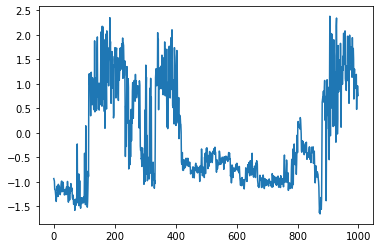

In [8]:
from matplotlib import pyplot as plt
plt.plot(x)

In [24]:
from torch.utils.data import Dataset, IterableDataset
class MyPositivesDataset(IterableDataset):
    def __iter__(self):
        return pos_generator
    
ds = MyPositivesDataset()


In [18]:
x,y = next(pos_generator)

In [25]:
type(x.flatten()[0])

numpy.float32

In [29]:
import pandas as pd
datapoints = []
for i in range(10):
    x_pos,y_pos = next(pos_generator)
    x_neg,y_neg = next(neg_generator)
    
    datapoints.append({'signal':x_pos.flatten(),'label':y_pos})
    datapoints.append({'signal':x_neg.flatten(),'label':y_neg})
    

df = pd.DataFrame(datapoints)
df.head()

,signal,label
0,"[0.4334362, 0.3651379, -0.4468524, 0.16783164,...",1
1,"[-0.06711848, -1.0582185, -1.0154988, -0.40887...",0
2,"[1.5616598, 0.92074126, 0.67026734, 1.4069552,...",1
3,"[0.632188, 0.35773617, -0.0029719055, 0.491041...",0
4,"[-0.2283518, -0.34231544, -0.22075394, -0.2131...",1


In [31]:
from datasets import Dataset, Sequence, Value, Features

features = Features({
    'signal': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
     'label': Value(dtype='int32', id=None),
})
raw_dataset = Dataset.from_pandas(df, features=features).shuffle(seed=42)
raw_dataset

Dataset({
    features: ['signal', 'label'],
    num_rows: 20
})

In [34]:
# def mappe(el):
#     print('MAPPOD')
#     return {'signal':el[0], 'label':el[1]}
    
# mapped = map(mappe,pos_generator)


In [35]:
# from datasets import IterableDataset as IterableDatasetHf
# ds_2 = IterableDatasetHf(mapped)
# # ds_2._head()

In [ ]:
#TODO model

In [40]:
from cnn_model import *

ImportError: cannot import name 'Batch' from 'torchtext.data' (/home/jovyan/my-conda-envs/RNAmodEnv/lib/python3.8/site-packages/torchtext/data/__init__.py)

In [38]:
from transformers import TrainingArguments, Trainer, AutoModelForAudioClassification

num_labels = 2
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels,# label2id=label2id, id2label=id2label
)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=raw_dataset,
    # tokenizer=feature_extractor,
)

trainer.train()
# model

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.weight', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.bias', 'quantizer.codevectors', 'project_hid.bias', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'projector.bias', 'classifier.w

TypeError: forward() missing 1 required positional argument: 'input_values'